---
title: "Tackling Tabular Problems IV: Models & Hyperparameter Optimization"
date: "2022-11-17"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

## Models

Like with previous aspects of the pipeline, there are no precise rules for picking the right model for a particular problem because the choice depends on a multitude of different factors. However, there are some rules of thumb (given that we are optimizing for the predictive power of our model):

- For smaller datasets (with several hundred to several thousand observations), linear models (e.g., ridge regression, logistic regression) generally work best. Random Forests or Support Vector Machines are also worth a try. Note that Nvidia's [`cuml`](https://github.com/rapidsai/cuml) library provides GPU acceleration for all these models.
- For larger datasets (from several thousand to hundreds of millions of observations), GBDTs are the gold standard. Their rule-based approach is ideally suited for the typical irregular patterns of tabular data, and with a large enough dataset overfitting can be prevented. Also, GBDTs (especially XGBoost) nowadays profit heavily from GPU acceleration. If the data comes from physical processes or simulations, however, neural networks will often shine since they are biased towards smooth solutions. This also holds when interpolation is very important (e.g., because the samples are quite far from each other) because the piecewise constant functions learned by tree-based models are not suited for interpolation. Furthermore, neural networks are the way to go for representation learning. Finally, if we need the best possible predictive performance, deep learning usually works well as a complement to tree-based models in ensembles. Have a look at this recent [paper](https://arxiv.org/pdf/2207.08815.pdf) for more on tree-based models and neural networks for tabular data.
- For huge datasets (with, say, more than a billion observations), neural networks are typically the best choice. 

## GBDT libraries and their hyperparameters

For the sake of brevity, we'll only dive deeper into GBDTs and their hyperparameters. We'll look at the most common implementations: XGBoost, LightGBM, CatBoost, and scikit-learn's HistGradientBoosting. 

Note: 

- Knowing how GBDTs work is a prequisite for understanding their hyperparameters; see [here](https://explained.ai/gradient-boosting/) for a thorough explanation.
- The tips below come from my own experience (especially XGBoost and LightGBM) as well as from other people's code and what I found online (CatBoost, HistGradientBoosting).

### XGBoost

[XGBoost](https://github.com/dmlc/xgboost) was the [first library](https://arxiv.org/pdf/1603.02754.pdf) that provided a highly optimized implementation of GBDTs. Nowadays, it is primarily developed by Nvidia leading to built-in GPU acceleration which massively speeds up model training.

Let's have a look at the most important hyperparameters:

- `n_estimators`: This is the number of trees fitted (which is equal to the number of boosting iterations). Generally a higher number of trees improves the model's performance (at least up to some point), but also increases the risk of overfitting. In general, around `1,000` trees should be enough; using many more is not needed in most problem settings (`5,000` should definitely be enough). Important: `n_estimators` has to be tuned in conjunction with the `learning_rate`. Thus, a good approach can be to set `n_estimators=1000` and try out different learning rates (or do a grid search) before proceeding with tuning other hyperparameters. After finding a good hyperparameter setting, we can still tune both the number of trees and the learning rate. (Note that this can be done the other way around, too. That is, we can set the learning rate so that around 1,000 trees are used, and continue from there.)
- `learning_rate`: A learning rate between `0.001` and `0.1` should work fine. Generally, a lower learning rate should be combined with a higher number of trees.
- `max_depth`: Apart from `n_estimators` and `learning_rate`, `max_depth` is probably the most important hyperparameter. It determines the maximum depth of the trees; with a higher `max_depth` the model becomes more complex but also more likely to overfit. When tuning by hand, this is the first hyperparameter (after the number of trees/learning rate) that should be tuned. It is also the first parameter to decrease if overfitting is a problem. In general, a value between `3` and `10` should be fine. Depending on the problem, it can make sense to go a bit higher. Note that a higher `max_depth` results in slower computation and higher memory usage.
- `min_child_weight`: Technically, `min_child_weight` is the minimum sum of instance weight needed in a child. In lay terms it regularizes the model by limiting the depth of the trees. Generally, a higher `min_child_weight` means a more conservative model. A good range for tuning is between `1` (the default value) and `300`.
- `colsample_bytree`: This is the subsample ratio of columns when constructing each tree. Subsampling columns when constructing each tree can make the training faster and more robust to noise. Typically, the best value is between `0.5` and `0.9` (or even `0.3` and `1.0`).
- `subsample`: This is the subsample ratio of the training instances (subsampling occurs once in every boosting iteration). Like `colsample_bytree`, using `subsample` helps prevent overfitting by introducing randomness in the training process. Typically, the best value is between `0.5` and `0.8` (or even `0.4` and `1.0`). `0.7` is often a good starting point. Making use of `colsample_bytree` and `subsample` leads to more different tree splits.
- `reg_alpha`, `reg_lambda`: While `alpha` represents the L1 regularization term on weights, `lambda` is the L2 regularization term. Increasing these hyperparameters translates to making the model more conservative. There are two things to note: First, adding regularization is not always better. Second, for GBDTs it tends to be better to set `alpha` to (near) zero, while using a higher `lambda`. A good range for tuning is between `0.001` and `10.0`.
- `max_bin`: The maximum number of bins to bucket numerical features. The default is `256`. Can be increased to build a more complex model, but comes with a higher risk of overfitting and slows down training.
- `gamma`: `gamma` represents the minimum loss reduction required to make a further partition on a leaf node of the tree. That is, gamma controls the complexity of the model and can be increased to combat overfitting. Since a good value for gamma is highly dependent on the data set and the other hyperparameters, it is difficult to give a good range for tuning. As per this [post](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6), it can help to increase `gamma` (the default is `0`; try `3`, `5`, or `10`, for example) if overfitting appears to be a huge problem. Values around 20 should only be used when the model uses a high `max_depth`.

Apart from `n_estimators` and `learning_rate`, it is typically enough to tune `max_depth`, `min_child_weight`, `colsample_bytree`, `subsample`, and `reg_alpha`/`reg_lambda`.

Notes:

- The XGBoost library provides two APIs: its original "Learning API" and a scikit-learn wrapper interface, the "Scikit-Learn API". Furthermore, XGBoost uses the custom data structure `DMatrix` to improve training speed and memory efficiency. For improved memory efficiency when training on the GPU the XGBoost library also provides the `DeviceQuantileDMatrix`.
- Set `objective` to define the objective function and `eval_metric` for the evaluation metric. XGBoost provides [many options](https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters) for regression, classification, and ranking tasks. See [here](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html) for defining custom objectives or evaluation metrics.
- Specify the `tree_method` as `gpu_hist` to use GPU acceleration. XGBoost supports fully distributed GPU training [using Dask](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html).
- Specify the `predictor` parameter to `cpu_predictor` to predict on the CPU or to `gpu_predictor` for using GPU accelerated prediction. Use `gpu_predictor` to compute SHAP values using GPU acceleration.
- When there are unbalanced classes, use `scale_pos_weight` to control the balance of positive and negative weights. A typical value is `sum(negative instances) / sum(positive instances)`. See [here](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset) for more tips and [here](https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-cv.py) for an example.
-  Depending on the problem, we may know that a given feature should generally have a positive or negative effect on the target (e.g., due to business constraints or scientific knowledge) or we may want to restrict the interaction of different features. XGBoost provides tutorials on using [monotonic constraints](https://xgboost.readthedocs.io/en/latest/tutorials/monotonic.html) and [feature interaction constraints](https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html).
- There is [experimental support](https://xgboost.readthedocs.io/en/stable/tutorials/multioutput.html) for multi-output regression.
- The integration with Apache Spark and Dask allows to handle huge volumes of data.
- There is a [callback](https://docs.wandb.ai/guides/integrations/xgboost) for Weights & Biases.

### LightGBM

[LightGBM](https://github.com/microsoft/LightGBM), developed by Microsoft, is an alternative to XGBoost. While XGBoost uses a level-wise strategy to grow trees (i.e., breadth-first search), LightGBM uses a leaf-wise growth strategy (i.e., depth-first search). This generally allows LightGBM to fit more quickly than XGBoost (at least when compared on CPUs).

- `n_estimators`: In LightGBM the optimal range for the number of trees appears to be somewhat wider than in XGBoost. Try values between 100 and 10,000. Increase the `learning_rate` when you decrease `n_estimators`.  Note that choosing the right values for the number of trees and the learning rate is highly dependent on the data and the objective.
- `learning_rate`: Try values between `0.001` and `0.1`. Use a small learning rate combined with a higher number of iterations to improve the accuracy of the model. Decrease the learning rate to combat overfitting.
- `max_depth`: Try values between `3` and `20`.
- `num_leaves`: The maximum number of final leaves for each tree and the main parameter to control the complexity of a LightGBM model. Can be between `2` and $2^{\text{max depth}}$.
- `min_data_in_leaf`: The minimum number of data points in one leaf. Very important parameter to prevent overfitting in a leaf-wise tree (like LightGBM). Its optimal value depends on the number of training samples and `num_leaves`. Setting it to a large value can avoid growing too deep trees, but may cause underfitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
- `max_bin`: The maximum of bins that each feature will be bucketed into. The default is `255`. Increasing `max_bin` up to, say, `400` allows more complexity but also increases the risk of overfitting. Decreasing `max_bin` can be used to speed up training.
- `colsample_bytree`: Try values between `0.3` and `1.0`.
- `subsample`: Try values between `0.1` and `1.0`.
- `subsample_freq`: The frequency (in terms of boosting iterations) at which LightGBM will subsample the training examples. If subsampling helps, try values between `1` and `10`.
- `reg_alpha`, `reg_lambda`: These are the same as in XGBoost.
- `min_gain_to_split`: Increase `min_gain_to_split` to combat overfitting. From the LightGBM docs: "When adding a new tree node, LightGBM chooses the split point that has the largest gain. Gain is basically the reduction in training loss that results from adding a split point. By default, LightGBM sets `min_gain_to_split` to `0.0`, which means 'there is no improvement that is too small'. However, in practice you might find that very small improvements in the training loss don’t have a meaningful impact on the generalization error of the model." 

Apart from `n_estimators` and `learning_rate`, it is typically enough to tune `num_leaves`, `min_data_in_leaf`, `colsample_bytree`, `subsample`, and `reg_alpha`/`reg_lambda`.

Notes:

- LightGBM provides two main APIs: the original "Training API" and a scikit-learn wrapper interface, the "Scikit-Learn API".
- Use the [`Dataset` class](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html) to handle data with LightGBM.
- It is [possible](https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html) to train LightGBM using GPUs. XGBoost, however, generally provides (much) better GPU acceleration.
- Set `objective` to define the objective function. See [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective) for the many options provided by LightGBM.
- Use `categorical_feature` to specify categorical features.
- In binary classification, use `is_unbalance` or `scale_pos_weight` to handle class imbalances. In multi-class classification tasks, use `class_weight`. Per the LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html), note that it may be necessary to [calibrate](https://scikit-learn.org/stable/modules/calibration.html) the resulting class probabilities.
- Since version 3.2.0 there is an [integration with Dask](https://lightgbm.readthedocs.io/en/latest/Python-API.html#training-api).
- Use `monotone_constraints` to set monotonic constraints.
- There is a [callback](https://docs.wandb.ai/guides/integrations/lightgbm) for Weights & Biases.

### CatBoost

[CatBoost](https://github.com/catboost/catboost) was originally developed by Yandex. As hinted by its name, CatBoost generally shines in datasets with many categorical features (CatBoost cleverly uses one-hot encoding and target encoding for this purpose). It can work really well with all kinds of datasets, however.

The eight most important hyperparameters:

- `n_estimators`: Try values between `100` and `1,000`. CatBoost's default is `1,000` trees; again, using many more typically isn't necessary.
- `learning_rate`: Try values between `0.001` and `0.1`. Use a small learning rate combined with a higher number of iterations to improve the accuracy of the model. Decrease the learning rate to combat overfitting.
- `max_depth`: Per the [CatBoost docs](https://catboost.ai/en/docs/concepts/parameter-tuning), the optimal depth ranges from `4` to `10` and values from `6` to `10` are recommended. CatBoost doesn't support values higher than `16`.
- `subsample`: Try values between `0.1` and `1.0`.
- `bagging_temperature`: Defines the settings of the Bayesian bootstrap which is used to assign random weights to objects. The default is `1.0`. A higher value translates to more aggressive bagging. If set to `0.0`, all weights are equal to `1`. 
- `random_strength`: Per the CatBoost docs, this parameter is used when selecting splits: "On every iteration each possible split gets a score (for example, the score indicates how much adding this split will improve the loss function for the training dataset). The split with the highest score is selected. The scores have no randomness. A normally distributed random variable is added to the score of the feature. It has a zero mean and a variance that decreases during the training. The value of this parameter is the multiplier of the variance." The default value is `1.0`. Try values between `1e-9` and `10.0`.
- `border_count`: The number of splits for numerical features. `128` should usually be enough. Set `border_count` to the default of `254` when training on the GPU to get the best possible performance. Larger values are generally not recommended and slow down training.
- `reg_lambda`: Try values between `2` and `30`.

Apart from `n_estimators` and `learning_rate`, it is typically enough to tune `max_depth`, `subsample`, `reg_lambda`, `random_strength`, and `bagging_temperature`.

Notes:

- The CatBoost API is [compatible](https://catboost.ai/en/docs/concepts/python-quickstart) with scikit-learn.
- CatBoost models can be trained on the GPU (`task_type="GPU"`). XGBoost, however, generally provides (much) better GPU acceleration.
- See [here](https://catboost.ai/en/docs/concepts/loss-functions) for more on objective functions and metrics in CatBoost.
- Use `cat_features` to specify categorical features.
- Use `class_weights` to specify class weights in classification problems.

### HistGradientBoosting

Inspired by LightGBM, scikit-learn has added its own versions of GBDTs: [`HistGradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html). They have less hyperparameters than the other implementations and are well worth a try.

- `max_iter`: This is the maximum number of trees fitted (i.e., equivalent to `n_estimators` in other libraries). The default value is 100. Try values between 100 and 10,000.
- `learning_rate`: Try values between `0.001` and `0.1`.
- `max_depth`: Try values between `3` and `12` (the ideal value is often around `6`). Note that the depth isn't constrained by default.
- `max_leaf_nodes`: The maximum number of leaves for each tree. The default is `31`. Depending on the dataset, try values in a larger range (e.g., between `2` and `500`).
- `min_samples_leaf`: The minimum number of samples per leaf. The default is `20`. Depending on the dataset, try values between `2` and `300`.
- `max_bins`: The default is `255` (one more bin is always reserved for missing values). Using less bins can help prevent overfitting, but isn't generally recommended by scikit-learn.
- `l2_regularization`: Comparable to `reg_lambda` in other libraries. The default is `0`. Try values up to `100`.

Notes:

- Use the `loss` parameter to set the loss function.
- Scikit-learn provides an example for using [monotonic constraints](https://scikit-learn.org/stable/auto_examples/ensemble/plot_monotonic_constraints.html#sphx-glr-auto-examples-ensemble-plot-monotonic-constraints-py) (set the `monotonic_cst` parameter). Setting [interaction constraints](https://scikit-learn.org/stable/modules/ensemble.html#interaction-constraints) is possible too (set the `interaction_cst` parameter).
- Use the `categorical_features` parameter to indicate categorical features.
- By default, early stopping is performed if there are at least 10,000 samples. We can control this behavior using the `early_stopping` parameter.

## Hyperparameter Optimization

Finding the right set of hyperparameters for a given problem can be very challenging. The automatic hyperparameter optimization methods that are briefly outlined below can generally be applied to any problems or models, not just tabular ones. Note: Before we can optimize hyperparameters, we of course need a model, a hyperparameter search space (i.e., a range of values for each hyperparameter), and a reliable CV scheme with an evaluation metric that we care about.

- **Grid search**: Grid search translates to searching exhaustively through all possible hyperparameter combinations. The algorithm is highly parallelizable, but naturally suffers from the curse of dimensionality and is therefore not feasible in a high-dimensional search space. We can use it in the rare cases that don't require a lot of tuning, though. Grid search is implemented by scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).
- **Random search**: Instead of trying every combinations, random search randomly samples the search space. Since this is generally feasible in high-dimensional spaces, doesn't waste time with testing slightly different combinations, and still has a good chance of finding a good set of hyperparameters, random search is quite common in practice. It is implemented in scikit-learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).
- **Halving search**: Both grid search and random search cannot recognize ineffective hyperparameters or search intervals. To remedy this, scikit-learn also provides hyperparameter optimization based on [successive halving](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) (SH). In the first iteration, the SH algorithm evaluates all parameter combinations with a small amount of resources (often the number of training samples). Then, it selects only the best candidates for the next iteration which in turn uses more resources for evaluation. This process continues in the following iterations (i.e., only a subset of candidates proceeds to the next round and the corresponding performance estimates get more precise since more resources are allocated for evaluation). Scikit-learn implements the SH algorithm in [`HalvingGridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV) and [`HalvingRandomSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV). 
- **Bayesian optimization**: Bayesian optimization (BO) is a more sophisticated approach. Unlike grid search or random search, BO optimizes a surrogate function instead of the true objective function (because the true objective function may be expensive to evaluate, noisy, and evaluation doen't give gradient information). In the beginning BO focuses on exploration to train the surrogate function, and then starts to exploit its approximate knowledge of the objective to sample more useful examples (i.e., hyperparameter combinations). For smooth search spaces, BO is typically based on Gaussian processes (with [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) being the most prominent example). An alternative for more complex search spaces are Tree Parzen Estimators (TPEs) which sample parameter combinations from a multivariate probability distribution. TPE is the default sampler used by [Optuna](https://github.com/optuna/optuna), a widely used tool for hyperparameter optimization. See [here](https://distill.pub/2020/bayesian-optimization/) for a nice and more in-depth explanation of Bayesian optimization.

Finally, some general tips for GBDT hyperparameter tuning:

- Focus on key hyperparameters. It isn't necessary to tune all available hyperparameters; instead focus on key hyperparameters that can be tuned intuitively.
- Stay conservative. Using huge search spaces for finding the best possible hyperparameter configuration usually results in overfitting to the validation data. Thus, blindly trusting the result of an Optuna study is generally not a good idea (we need to at least check the best trials for consistency).
- Don't tune the hyperparameters too often. After the hyperparameters of a model have been tuned, the results cannot be reliably compared to older runs. Tune the hyperparameters of the model when the feature engineering is complete (and maybe once when a useful basic set of features has been created). 
- Don't use early stopping. Instead of using a different number of trees for each fold (inevitably leading to overfitting), select the number of trees that works best across folds. We generally wouldn't use different hyperparameters for our folds; this applies to the number of trees too. Also, using early stopping complicates retraining on the full dataset.
- With some experience, tuning GBDTs manually can be a quite intuitive method for hyperparameter optimization (and get better results in less trials than Optuna). An example for XGBoost: Set `n_estimators=1000` and choose an adequate learning rate. Then, try some reasonable values for `max_depth` and plot the corresponding CV scores (we should be able to see whether we need to try more values). Proceed like this with `min_child_weight`, `colsample_bytree`, `subsample`, and `reg_alpha`/`reg_lambda`. This way, we'll gather a better understanding of the role of each hyperparameter. In the end, see whether changes to the number of trees and/or the learning rate can lead to further improvements.

## Example: Rocket League

We're ready to finalize our Rocket League example. Let's tune the hyperparameters of the XGBoost model developed in the last post and see whether we can improve our CV score even further.

In [1]:
import pandas as pd
import cudf
import cupy
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from pathlib import Path
import re
import gc

In [ ]:
data_path = Path("/kaggle/input/rocket-league-ds")

train_df = cudf.read_feather(data_path/"train_fe.feather")
test_df = cudf.read_feather(data_path/"test_fe.feather")

target = "team_A_scoring_within_10sec"
features = [col for col in train_df if col != target]

In [8]:
xgb_params = { 
    "eval_metric":"logloss",
    "objective":"binary:logistic",
    "tree_method":"gpu_hist",
    "predictor":"gpu_predictor",
    "random_state":1,
}

The `optimize` function, which we'll use for tuning the hyperparameters by hand, is pretty simple. It takes the name of a parameter and the corresponding search space, and it outputs the CV score for each parameter value as well as a plot showing all experiments.

In [9]:
#| code-fold: show

def optimize(df, param, search_space):
    cv = GroupKFold(n_splits=5)
    oof = np.zeros(df.shape[0])
    run_scores = []
    
    for run, val in enumerate(search_space):
        xgb_params[param] = val
        fold_scores = []
        
        for fold, (train_idx, valid_idx) in enumerate(cv.split(df, groups=df.game_num.to_numpy())):        
            dtrain = xgb.DMatrix(data=df.iloc[train_idx][features], label=df.iloc[train_idx][target])
            dvalid = xgb.DMatrix(data=df.iloc[valid_idx][features], label=df.iloc[valid_idx][target])
            
            model = xgb.train(xgb_params,
                              dtrain=dtrain,
                              evals=[(dtrain, "train"), (dvalid, "valid")],
                              num_boost_round=1000,
                              verbose_eval=False)

            oof_preds = model.predict(dvalid)
            oof[valid_idx] = oof_preds

            fold_score = log_loss(df.iloc[valid_idx][target].to_numpy(), oof_preds)
            fold_scores.append(fold_score)
            
        run_score = np.mean(fold_scores)
        run_scores.append(run_score)
        print(f"Run {run} with {param}={val:.4f} finished with score: {run_score:.5f}")
        
    print(f"Best run: {param}={search_space[np.argmin(run_scores)]} with score {np.min(run_scores)}")
    
    _, ax = plt.subplots(figsize=(6, 3))
    ax.scatter(search_space, run_scores)
    ax.set(xlabel=param, ylabel="CV score");

Let's see how this works in practice. Having set the number of trees (`num_boost_round`) to `1000`, we begin by trying different values for the learning rate. Plotting the results helps us determine the optimal value for this parameter.

Run 0 with learning_rate=0.0010 finished with score: 0.31120
Run 1 with learning_rate=0.0022 finished with score: 0.21784
Run 2 with learning_rate=0.0046 finished with score: 0.19517
Run 3 with learning_rate=0.0100 finished with score: 0.19302
Run 4 with learning_rate=0.0215 finished with score: 0.19224
Run 5 with learning_rate=0.0464 finished with score: 0.19221
Run 6 with learning_rate=0.1000 finished with score: 0.19370
Best run: learning_rate=0.046415888336127774 with score 0.19221204071717607


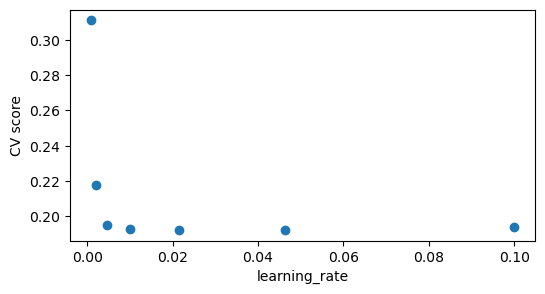

In [10]:
#| code-fold: show
optimize(train_df, "learning_rate", np.logspace(np.log10(0.001), np.log10(0.1), 7))

We set the parameter to `0.045` and from now on treat it as fixed:

In [11]:
#| code-fold: show

xgb_params["learning_rate"] = 0.045

Now we proceed in the same way with the other hyperparameters that we want to tune. 

Note: This may seem like a bad approach due to the complex dependencies between different hyperparameters which are often said to require an extensive grid search for tuning. In my experience though, manual tuning is an intuitive and, even more importantly, competitive approach to hyperparameter optimization that doesn't end in bad surprises (that is, bad test scores) and improves our understanding of key hyperparameters along the way.

Run 0 with max_depth=3.0000 finished with score: 0.19328
Run 1 with max_depth=4.0000 finished with score: 0.19248
Run 2 with max_depth=5.0000 finished with score: 0.19219
Run 3 with max_depth=6.0000 finished with score: 0.19224
Run 4 with max_depth=7.0000 finished with score: 0.19251
Run 5 with max_depth=8.0000 finished with score: 0.19311
Best run: max_depth=5 with score 0.19218715537697664


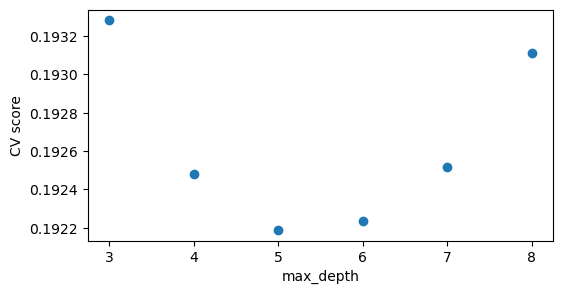

In [12]:
#| code-fold: show
optimize(train_df, "max_depth", range(3, 9))

In [13]:
#| code-fold: show
xgb_params["max_depth"] = 5

Run 0 with colsample_bytree=0.3000 finished with score: 0.19274
Run 1 with colsample_bytree=0.4000 finished with score: 0.19251
Run 2 with colsample_bytree=0.5000 finished with score: 0.19239
Run 3 with colsample_bytree=0.6000 finished with score: 0.19228
Run 4 with colsample_bytree=0.7000 finished with score: 0.19222
Run 5 with colsample_bytree=0.8000 finished with score: 0.19221
Run 6 with colsample_bytree=0.9000 finished with score: 0.19216
Run 7 with colsample_bytree=1.0000 finished with score: 0.19217
Best run: colsample_bytree=0.9000000000000001 with score 0.19216419980671837


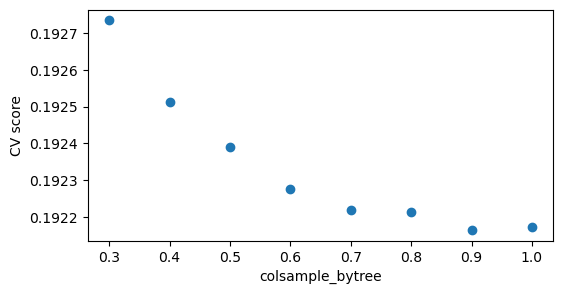

In [15]:
#| code-fold: show
optimize(train_df, "colsample_bytree", np.arange(0.3, 1.1, 0.1))

In [16]:
#| code-fold: show
xgb_params["colsample_bytree"] = 0.9

Run 0 with subsample=0.6000 finished with score: 0.19204
Run 1 with subsample=0.7000 finished with score: 0.19204
Run 2 with subsample=0.8000 finished with score: 0.19200
Run 3 with subsample=0.9000 finished with score: 0.19207
Best run: subsample=0.7999999999999999 with score 0.191996017796013


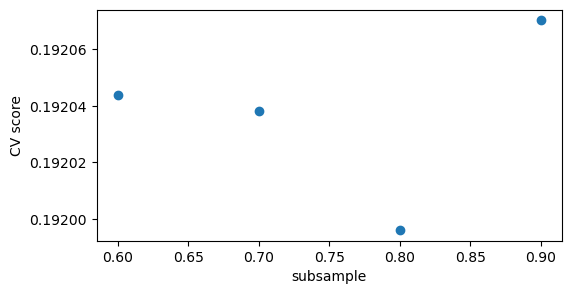

In [17]:
#| code-fold: show
optimize(train_df, "subsample", np.arange(0.6, 1., 0.1))

In [18]:
#| code-fold: show
xgb_params["subsample"] = 0.8

We have now determined our final values for the `learning_rate`, `max_depth`, `colsample_bytree`, and `subsample` hyperparameters.

Let's compute the test score:

In [21]:
model = xgb.train(xgb_params,
                  dtrain=xgb.DMatrix(data=train_df[features], label=train_df[target]),
                  num_boost_round=1000)
preds = model.predict(xgb.DMatrix(data=test_df[features]))

In [23]:
log_loss(test_df[target].to_numpy(), preds)

0.19447658866057935